# 11장 CNN을 활용한 이미지 인식

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [1]:
# 한글 폰트 설치

# !sudo apt-get install -y fonts-nanum* | tail -n 1
# !sudo fc-cache -fv
# !rm -rf ~/.cache/matplotlib

In [2]:
# 필요 라이브러리 설치

# !pip install torchviz | tail -n 1
# !pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [3]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [4]:
import torch
from torch import nn, optim
from torchinfo import summary
from torchviz import make_dot
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
# 기본 폰트 설정
# 윈도우에서는 "malgun.ttf" 혹은 "NanumBarunGothic.ttf" 등을 사용할 수 있다. 맥에서는 "AppleGothic.ttf"
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'


# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [6]:
x = 1.0
lr = 0.1
epochs = 20

for i in range(epochs):
    grad = 2 * x  
    x = x - lr * grad
    loss = x**2
    print(f"Epoch {i+1}: x = {x:.5f}, Loss = {loss:.5f}")

Epoch 1: x = 0.80000, Loss = 0.64000
Epoch 2: x = 0.64000, Loss = 0.40960
Epoch 3: x = 0.51200, Loss = 0.26214
Epoch 4: x = 0.40960, Loss = 0.16777
Epoch 5: x = 0.32768, Loss = 0.10737
Epoch 6: x = 0.26214, Loss = 0.06872
Epoch 7: x = 0.20972, Loss = 0.04398
Epoch 8: x = 0.16777, Loss = 0.02815
Epoch 9: x = 0.13422, Loss = 0.01801
Epoch 10: x = 0.10737, Loss = 0.01153
Epoch 11: x = 0.08590, Loss = 0.00738
Epoch 12: x = 0.06872, Loss = 0.00472
Epoch 13: x = 0.05498, Loss = 0.00302
Epoch 14: x = 0.04398, Loss = 0.00193
Epoch 15: x = 0.03518, Loss = 0.00124
Epoch 16: x = 0.02815, Loss = 0.00079
Epoch 17: x = 0.02252, Loss = 0.00051
Epoch 18: x = 0.01801, Loss = 0.00032
Epoch 19: x = 0.01441, Loss = 0.00021
Epoch 20: x = 0.01153, Loss = 0.00013


### GPU 확인하기

In [7]:
# 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## CNN의 처리 개요

In [8]:
data_root = './data'

# 샘플 손글씨 숫자 데이터 가져오기
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,
    train = True,
    download = True,
    transform = transform)

image, label = train_set[0]  # torch.Size([1, 28, 28])
image = image.view(1,1,28,28)

In [9]:
# 대각선상에만 가중치를 갖는 특수한 합성곱 함수를 만듦
conv1 = nn.Conv2d(1, 1, 3)
print("conv1.weight.shape = ", conv1.weight.shape) # [outputs, channel, kernel size (3x3)]
print("="*50)
print("conv1.weight = \n", conv1.weight)
print("conv1.bias = ", conv1.bias)

# bias를 0으로
nn.init.constant_(conv1.bias, 0.0)
# conv1.bias.data = torch.tensor([0]).float()

conv1.weight.shape =  torch.Size([1, 1, 3, 3])
conv1.weight = 
 Parameter containing:
tensor([[[[-0.0238, -0.1885, -0.1087],
          [-0.0826, -0.2910,  0.2183],
          [ 0.2398,  0.2371, -0.0546]]]], requires_grad=True)
conv1.bias =  Parameter containing:
tensor([0.0512], requires_grad=True)


Parameter containing:
tensor([0.], requires_grad=True)

In [10]:

# weight를 특수한 값으로
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
print("w1_np = \n", w1_np)
w1 = torch.tensor(w1_np).float() # torch.Size([3, 3])
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1
# conv1.weight

w1_np = 
 [[0 0 1]
 [0 1 0]
 [1 0 0]]


In [11]:
# 손글씨 숫자에 3번 합성곱 처리를 함
import cv2

image, label = train_set[0] # torch.Size([1, 28, 28])
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

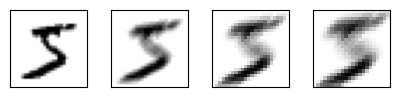

In [12]:
# 결과 화면 출력

plt.figure(figsize=(5, 1))
for i in range(4):
    size = (28 - i*2)
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### nn.Conv2d 와 nn.MaxPool2d

In [13]:
# CNN 모델 전반 부분, 레이어 함수 정의
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1, groups=1,
#                 bias=True, padding_mode='zeros', device=None, dtype=None)

conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))

print("conv1.weight.shape = \n", conv1.weight.shape)

conv1.weight.shape = 
 torch.Size([32, 3, 3, 3])


In [14]:
# conv1 확인
print("conv1")
print(conv1)

# conv1 내부 변수의 shape 확인
print(conv1.weight.shape) # torch.Size([32, 3, 3, 3]), (N, C, H, W)
print(conv1.bias.shape)

# conv2 내부 변수의 shape 확인
print("="*50)
print("conv2")
print(conv2.weight.shape)
print(conv2.bias.shape)

conv1
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
conv2
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [15]:
# conv1의 weight[0]는 0번째 출력 채널의 가중치
w = conv1.weight[0]

# weight[0]의 shape과 값 확인
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[ 0.0796  0.1307 -0.0738]
  [ 0.1874 -0.1616 -0.0686]
  [ 0.0231 -0.0145  0.1435]]

 [[-0.0486  0.1904  0.1908]
  [ 0.1672 -0.0624 -0.0154]
  [-0.086   0.0601  0.0832]]

 [[-0.0337  0.0129 -0.1135]
  [-0.182   0.0217 -0.1799]
  [ 0.0386  0.1781  0.0177]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4748855..3.891081].


torch.Size([100, 3, 32, 32])


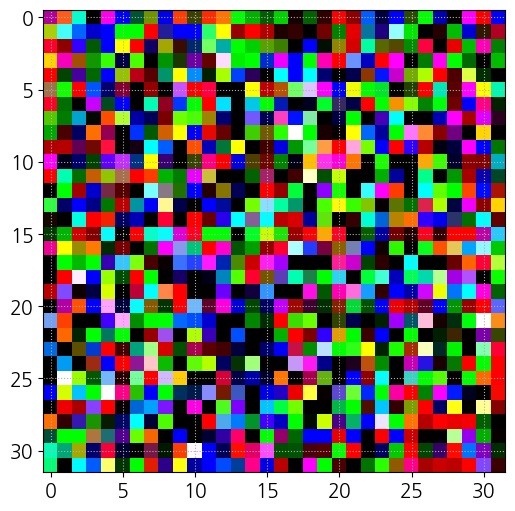

In [16]:
# 더미로 입력과 같은 사이즈를 갖는 텐서를 생성
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

## image show
plt.imshow(inputs[0].permute(1, 2, 0))
plt.show()

In [17]:
inputs.shape

torch.Size([100, 3, 32, 32])

In [18]:
# CNN 전반부 처리 시뮬레이션

x1 = conv1(inputs) # input size = torch.Size([100, 3, 32, 32])
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [19]:
# 각 변수의 shape 확인

print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [20]:
# conv1 = nn.Conv2d(3, 32, 3)
# relu = nn.ReLU(inplace=True)
# conv2 = nn.Conv2d(32, 32, 3)
# maxpool = nn.MaxPool2d((2, 2))

# 함수 정의
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

# 동작 테스트
outputs = features(inputs)

In [21]:
# 동작 테스트
outputs = features(inputs)

# 결과 확인
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [22]:
# 함수 정의
flatten = nn.Flatten()

# 동작 테스트
outputs2 = flatten(outputs)

# 결과 확인
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


### eval_loss(손실 계산)

In [23]:
# 손실 계산용
def eval_loss(loader, device, net, criterion):

    # 데이터로더에서 처음 한 개 세트를 가져옴
    for images, labels in loader:
        break

    # 디바이스 할당
    inputs = images.to(device)
    labels = labels.to(device)

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    return loss

### fit(학습)

In [24]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history) # => 0
    batch_size_train = len(train_loader)
    batch_size_test = len(test_loader)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train() # dropout, batch normalization 활성화
        # count = 0

        for inputs, labels in tqdm(train_loader):
            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item() /len(labels)

            # 손실과 정확도 계산
        avg_train_loss = train_loss / batch_size_train
        avg_train_acc = train_acc / batch_size_train

        # 예측 페이즈
        net.eval()
        # count = 0

        for inputs, labels in test_loader:
            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item() /len(labels)

            # 손실과 정확도 계산
        avg_val_loss = val_loss / batch_size_test
        avg_val_acc = val_acc / batch_size_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### eval_history(학습 로그)

In [25]:
# 학습 로그 해석

def evaluate_history(history):
    # 손실과 정확도 확인
    print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}')
    print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='훈련')
    plt.plot(history[:,0], history[:,3], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('손실')
    plt.title('학습 곡선(손실)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='훈련')
    plt.plot(history[:,0], history[:,4], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('정확도')
    plt.title('학습 곡선(정확도)')
    plt.legend()
    plt.show()

### show_images_labels(예측 결과 표시)

In [26]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)
    print("n_size = ", n_size)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


### torch_seed(난수 초기화)

In [27]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True #
    torch.use_deterministic_algorithms = True

### 데이터 준비

In [28]:
# Transforms의 정의

# transformer1 1계 텐서화

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 정규화만 실시

# 검증 데이터용 : 정규화만 실시
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [29]:
# 데이터 취득용 함수 datasets

data_root = './data'

# 훈련 데이터셋 (1계 텐서 버전)
train_set1 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform1)

# 검증 데이터셋 (1계 텐서 버전)
test_set1 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform1)

# 훈련 데이터셋 (3계 텐서 버전)
train_set2 = datasets.CIFAR10(
    root =  data_root,
    train = True,
    download = True,
    transform = transform2)

# 검증 데이터셋 (3계 텐서 버전)
test_set2 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform2)

### 데이터셋 확인

In [30]:
len(train_set1)

50000

In [31]:
image1, label1 = train_set1[0] # 3 x 32 x 32 = [3072]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [32]:
# 데이터로더 정의

# 미니 배치 사이즈 지정
batch_size = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False)

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용이므로 셔플하지 않음
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False)


In [33]:
len(train_loader1)

500

In [34]:
# train_loader1에서 한 세트 가져오기
for images1, labels1 in train_loader1:
    break

# train_loader2에서 한 세트 가져오기
for images2, labels2 in train_loader2:
    break

#
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


n_size =  50


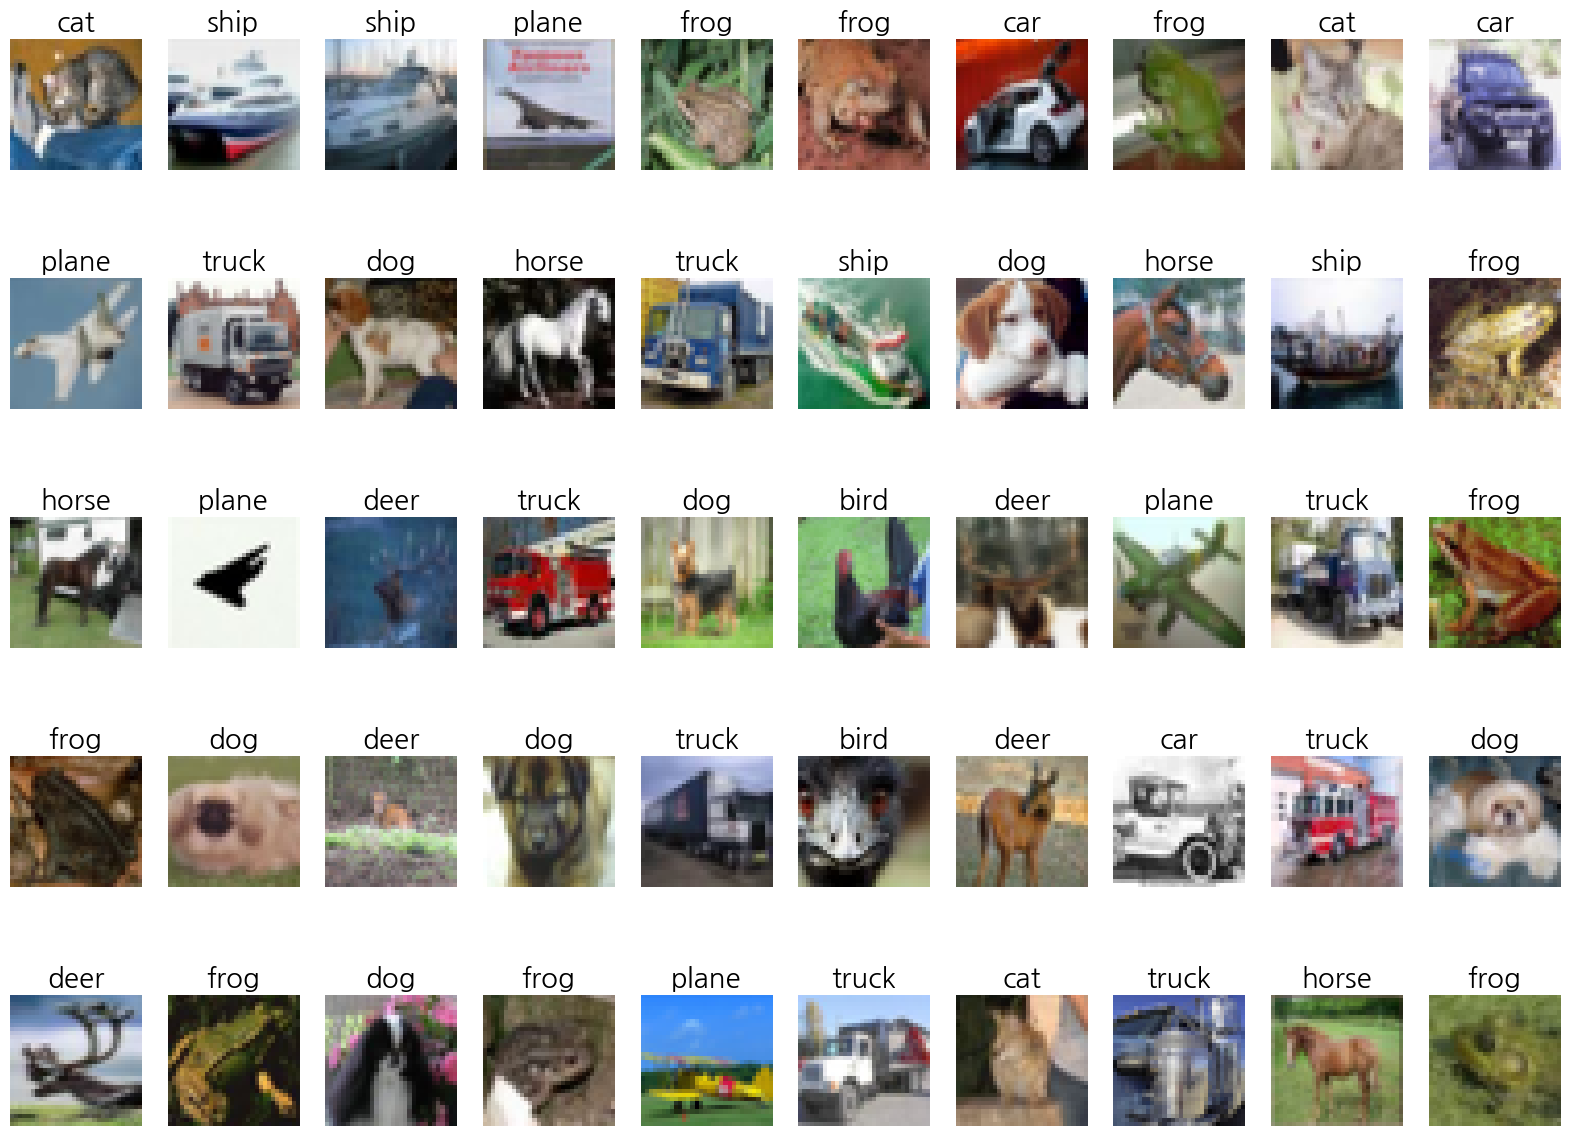

In [35]:
# 정답 라벨 정의
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 검증 데이터의 처음 50개를 출력
show_images_labels(test_loader2, classes, None, None)

### 학습용 파라미터 설정

In [36]:
# 입력 차원수는 3*32*32=3072
n_input = image1.view(-1).shape[0]

# 출력 차원수
# 분류 클래스의 수이므로　10
n_output = len(set(list(labels1.data.numpy())))
# np.unique(labels1.data.numpy()).size
# 은닉층의 노드수
n_hidden = 128

# 결과 확인
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [37]:
# 모델 정의
# 3072입력 10출력 1은닉층을 포함한 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 은닉층 정의(은닉층의 노드수 : n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 출력층의 정의
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### 모델 인스턴스 생성과 GPU 할당

In [38]:
# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [39]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [40]:
# 모델 개요 표시 2

summary(net, (100, 3072), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [100, 10]                 --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

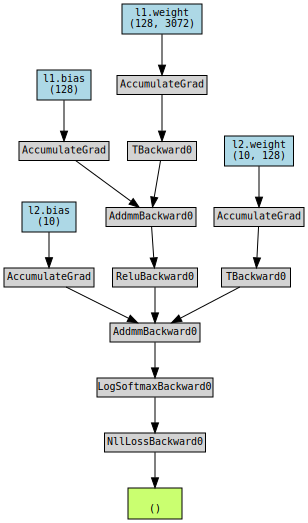

In [41]:
# 손실 계산
loss = eval_loss(test_loader1, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 학습

In [42]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history = np.zeros((0,5))

# 학습
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

ModuleNotFoundError: No module named 'tqdm'

### 평가

초기상태 : 손실 : 1.79424  정확도 : 0.37710
최종상태 : 손실 : 1.46307  정확도 : 0.48860


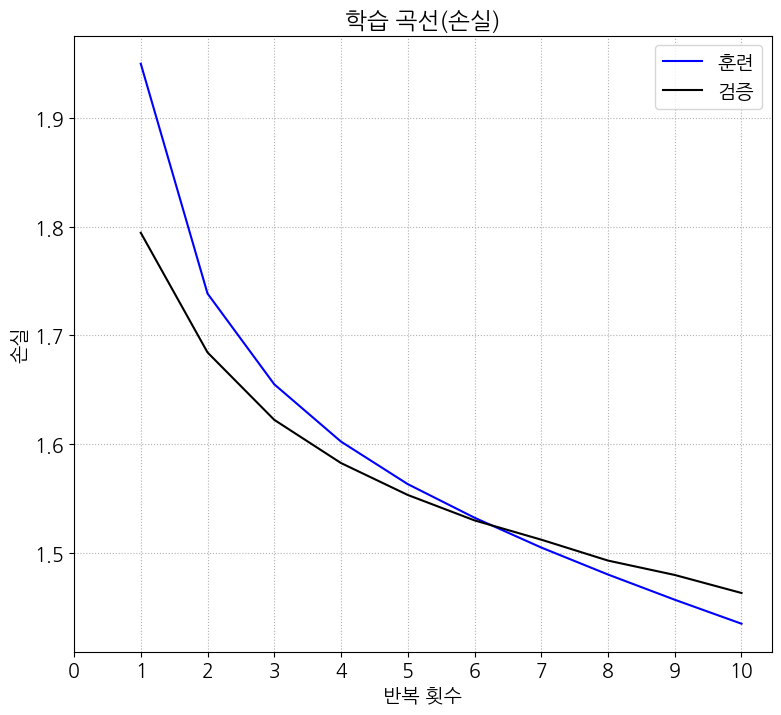

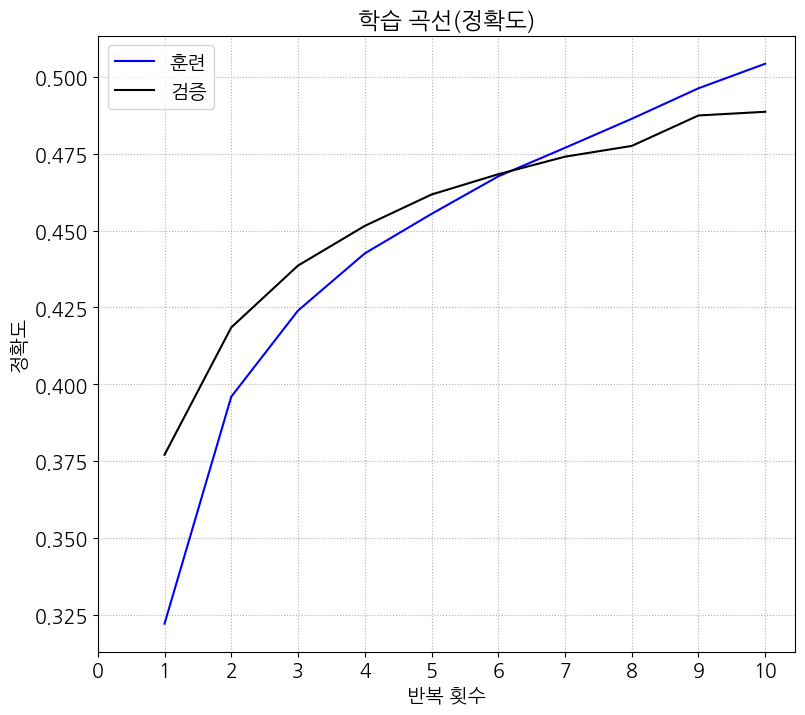

In [ ]:
# 평가
evaluate_history(history)

### 모델 정의(CNN)

In [ ]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

### 모델 인스턴스 생성

In [ ]:
# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# 모델 개요 표시 1

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# 모델 개요 표시2

summary(net, (100,3,32,32), depth = 2)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         9,248
│    └─Conv2d: 2-1                       [100, 32, 30, 30]         896
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [100, 32, 30, 30]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [100, 32, 28, 28]         9,248
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [100, 32, 28, 28]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [100, 32, 14, 14]         --
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [

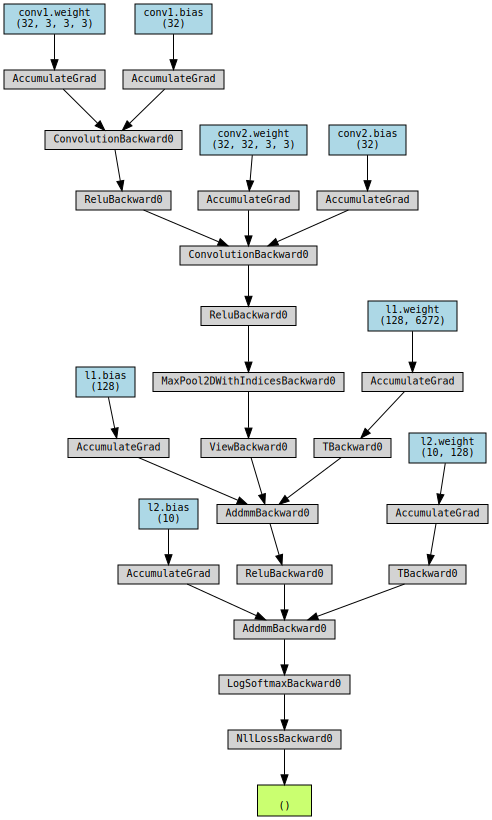

In [ ]:
# 손실 계산
loss = eval_loss(test_loader2, device, net, criterion)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 결과(CNN)

In [ ]:
# 난수 초기화
torch_seed()

# 모델 인스턴스 생성
net = CNN(n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 학습률
lr = 0.01

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history2 = np.zeros((0,5))

# 학습
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10], loss: 2.08246 acc: 0.26084 val_loss: 1.86593, val_acc: 0.34690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.78080 acc: 0.37296 val_loss: 1.67678, val_acc: 0.40950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/10], loss: 1.61318 acc: 0.43058 val_loss: 1.53056, val_acc: 0.45960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/10], loss: 1.48527 acc: 0.47320 val_loss: 1.44834, val_acc: 0.49010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/10], loss: 1.40808 acc: 0.49936 val_loss: 1.37022, val_acc: 0.51260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/10], loss: 1.34984 acc: 0.52108 val_loss: 1.33102, val_acc: 0.52650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/10], loss: 1.30325 acc: 0.53764 val_loss: 1.29277, val_acc: 0.53840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/10], loss: 1.25244 acc: 0.55482 val_loss: 1.25406, val_acc: 0.55170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/10], loss: 1.20528 acc: 0.57400 val_loss: 1.23566, val_acc: 0.56080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/10], loss: 1.15801 acc: 0.59202 val_loss: 1.18459, val_acc: 0.58010


초기상태 : 손실 : 1.86593  정확도 : 0.34690
최종상태 : 손실 : 1.18459  정확도 : 0.58010


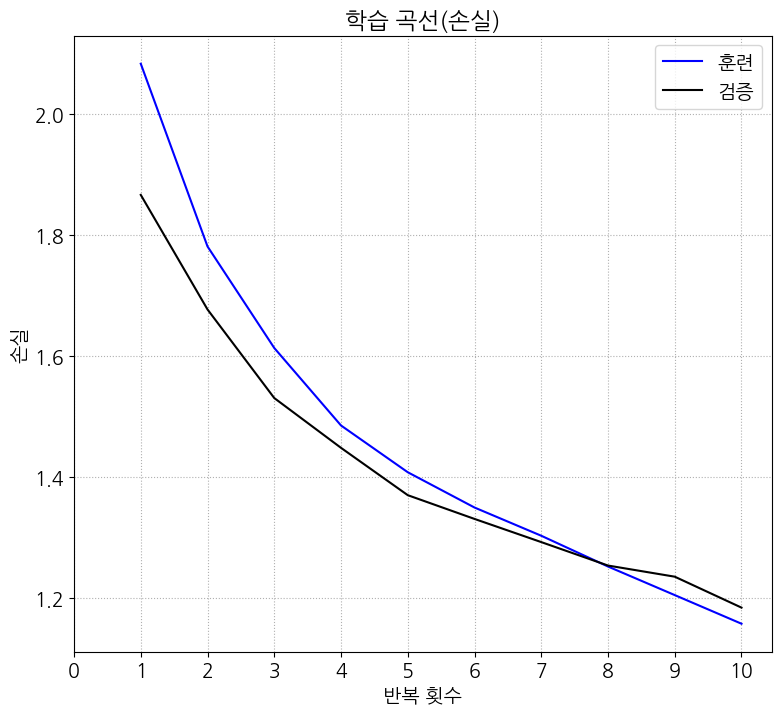

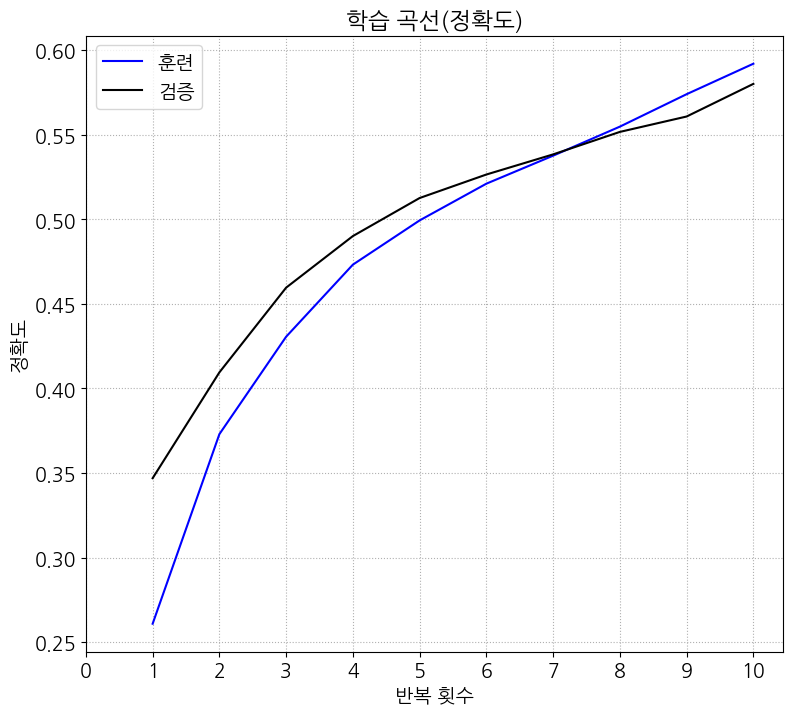

In [ ]:
# 평가

evaluate_history(history2)

n_size =  50


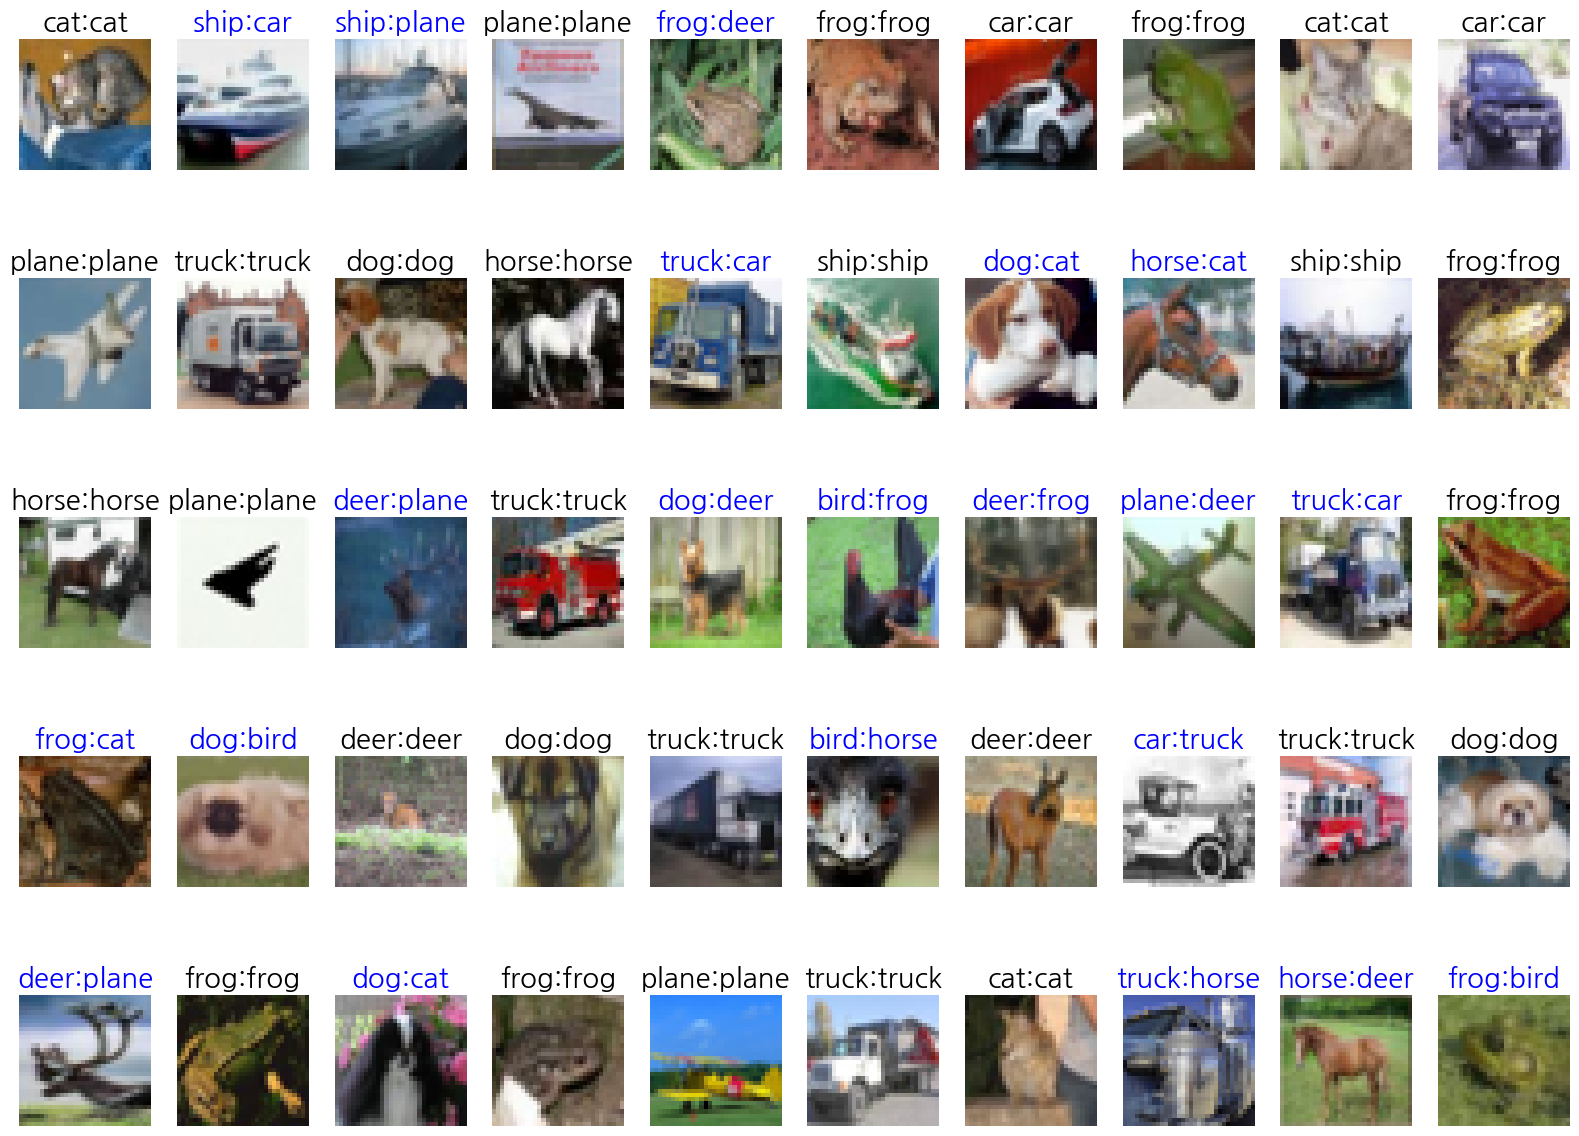

In [ ]:
# 처음 50개 데이터 표시

show_images_labels(test_loader2, classes, net, device)